In [9]:
#Use matplotlib to import libraries & define functions for plotting data.
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np #linear algebra
import os #accessing directory structure
import pandas as pd 
# read from a zipped CSV and avoid UnicodeDecodeError by using a permissive encoding


In [10]:
import zipfile

zip_path = 'GlobalTerrorismData.zip'

if os.path.exists(zip_path):
	if zipfile.is_zipfile(zip_path):
		with zipfile.ZipFile(zip_path) as z:
			print(z.namelist())
	else:
		try:
			# fall back in case it's actually a directory
			print(os.listdir(zip_path))
		except NotADirectoryError:
			print(f"'{zip_path}' exists but is not a zip file nor a directory.")
else:
	print(f"'{zip_path}' not found.")

['globalterrorismdb_0718dist.csv']


In [11]:
#Distribution graphs (histograms/bar graphs) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6*nGraphPerRow, 8*nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDF = df.iloc[:, i]
        if (not np.issubdtype(type(columnDF.iloc[0]), np.number)):
            valueCounts = columnDF.value_counts()
            valueCounts.plot.bar()
        else:
            columnDF.hist()
        plt.ylabel('counts')
        plt.xticks(rotation=90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [39]:
#Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns with more than 1 unique value
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN columns ({df.shape[1]}) is less than 2.')
        return
    corr = df.corr()
    plt.figure(num = None, figsize = (graphWidth, graphWidth), dpi = 80, facecolor = 'w', edgecolor = 'k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation = 90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize = 15)
    plt.show()


In [13]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include = [np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] #keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) >10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha = 0.75, figsize = [plotSize, plotSize], diagonal = 'kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords = 'axes fraction', ha = 'center', va = 'center', size = textSize)
    plt.suptitle('Scatter and Density Plot Matrix')
    plt.show()
        

In [41]:
print(df.shape)
print(df.columns.tolist())
print(df.head())
print(df.dtypes.value_counts())

(181691, 135)
['eventid', 'iyear', 'imonth', 'iday', 'approxdate', 'extended', 'resolution', 'country', 'country_txt', 'region', 'region_txt', 'provstate', 'city', 'latitude', 'longitude', 'specificity', 'vicinity', 'location', 'summary', 'crit1', 'crit2', 'crit3', 'doubtterr', 'alternative', 'alternative_txt', 'multiple', 'success', 'suicide', 'attacktype1', 'attacktype1_txt', 'attacktype2', 'attacktype2_txt', 'attacktype3', 'attacktype3_txt', 'targtype1', 'targtype1_txt', 'targsubtype1', 'targsubtype1_txt', 'corp1', 'target1', 'natlty1', 'natlty1_txt', 'targtype2', 'targtype2_txt', 'targsubtype2', 'targsubtype2_txt', 'corp2', 'target2', 'natlty2', 'natlty2_txt', 'targtype3', 'targtype3_txt', 'targsubtype3', 'targsubtype3_txt', 'corp3', 'target3', 'natlty3', 'natlty3_txt', 'gname', 'gsubname', 'gname2', 'gsubname2', 'gname3', 'gsubname3', 'motive', 'guncertain1', 'guncertain2', 'guncertain3', 'individual', 'nperps', 'nperpcap', 'claimed', 'claimmode', 'claimmode_txt', 'claim2', 'claim

In [17]:
nRowsRead = 1000 # specify 'None' if want to read whole file
# globalterrorismdb_0718dist.csv has 181691 rows in reality, but we are only loading/previewing the first 1000 rows
csv_name = 'globalterrorismdb_0718dist.csv'

if os.path.exists(csv_name):
	# read CSV directly if present
	df1 = pd.read_csv(csv_name, delimiter=',', nrows=nRowsRead, encoding='latin1')
	source = csv_name
elif os.path.exists(zip_path) and zipfile.is_zipfile(zip_path):
	# try to read the CSV from the zip archive
	with zipfile.ZipFile(zip_path) as z:
		namelist = z.namelist()
		# prefer exact match, otherwise pick the first CSV in the archive
		member = next((n for n in namelist if n.endswith(csv_name)), None)
		if member is None:
			member = next((n for n in namelist if n.lower().endswith('.csv')), None)
		if member is None:
			raise FileNotFoundError(f"CSV file '{csv_name}' not found inside zip '{zip_path}'. Contents: {namelist}")
		with z.open(member) as f:
			df1 = pd.read_csv(f, delimiter=',', nrows=nRowsRead, encoding='latin1')
	source = f"{zip_path}:{member}"
else:
	raise FileNotFoundError(f"Neither '{csv_name}' nor zip archive '{zip_path}' found.")

df1.dataframeName = csv_name
nRow, nCol = df1.shape
print(f'Read {nRow} rows and {nCol} columns from {source}')

Read 1000 rows and 135 columns from GlobalTerrorismData.zip:globalterrorismdb_0718dist.csv


In [43]:
df1.head(1)

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN


In [44]:
import numpy as np
import matplotlib.pyplot as plt

def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    # Keep columns with between 2 and 49 unique values (1 is constant so skipped)
    df = df[[col for col in df.columns if 1 < nunique[col] < 50]]

    n_cols = min(nGraphShown, len(df.columns))
    if n_cols == 0:
        print("No columns satisfy the uniqueness criterion.")
        return

    n_rows = int(np.ceil(n_cols / nGraphPerRow))

    plt.figure(figsize=(nGraphPerRow * 5, n_rows * 4))

    for i, col in enumerate(df.columns[:n_cols], start=1):
        plt.subplot(n_rows, nGraphPerRow, i)
        # Simple rule: bar for few unique values, hist for many
        if df[col].dtype == "object" or nunique[col] < 20:
            df[col].value_counts().sort_index().plot(kind="bar")
        else:
            df[col].hist(bins=30)
        plt.title(col)
        plt.tight_layout()

    plt.show()


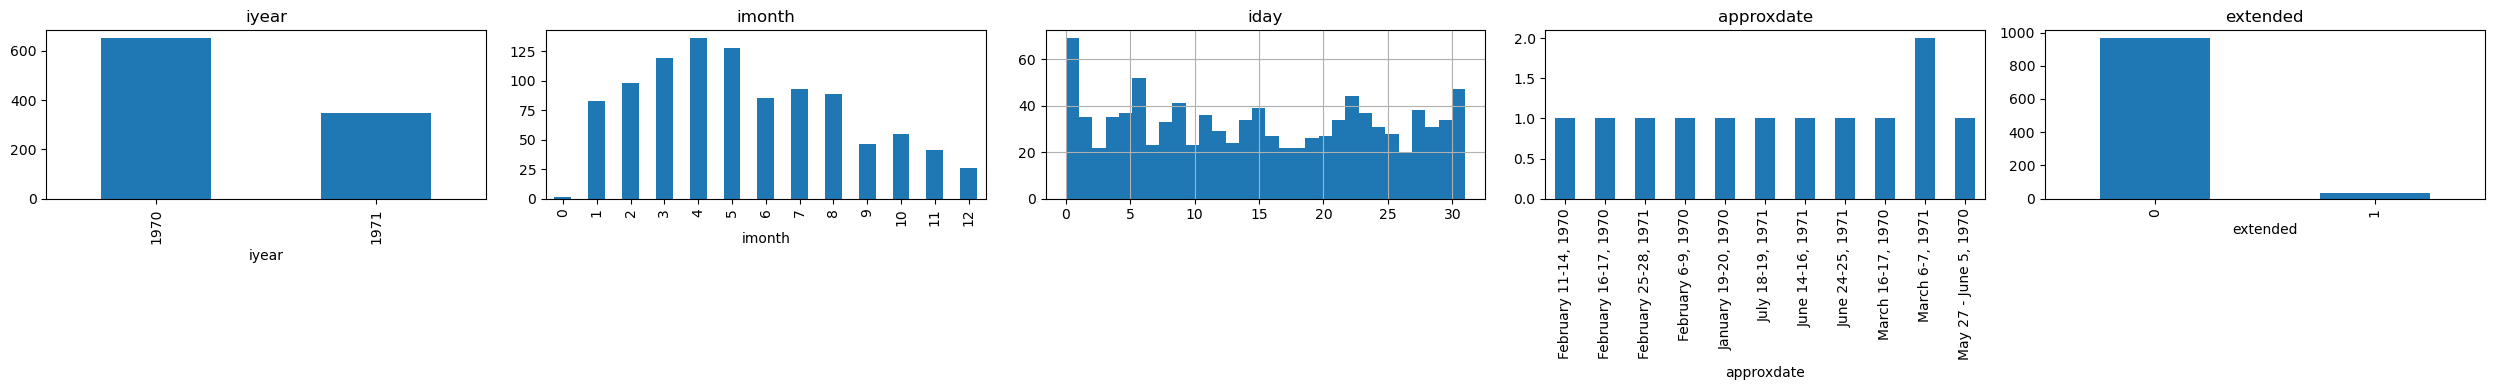

In [48]:
plotPerColumnDistribution(df1, 5, 20)


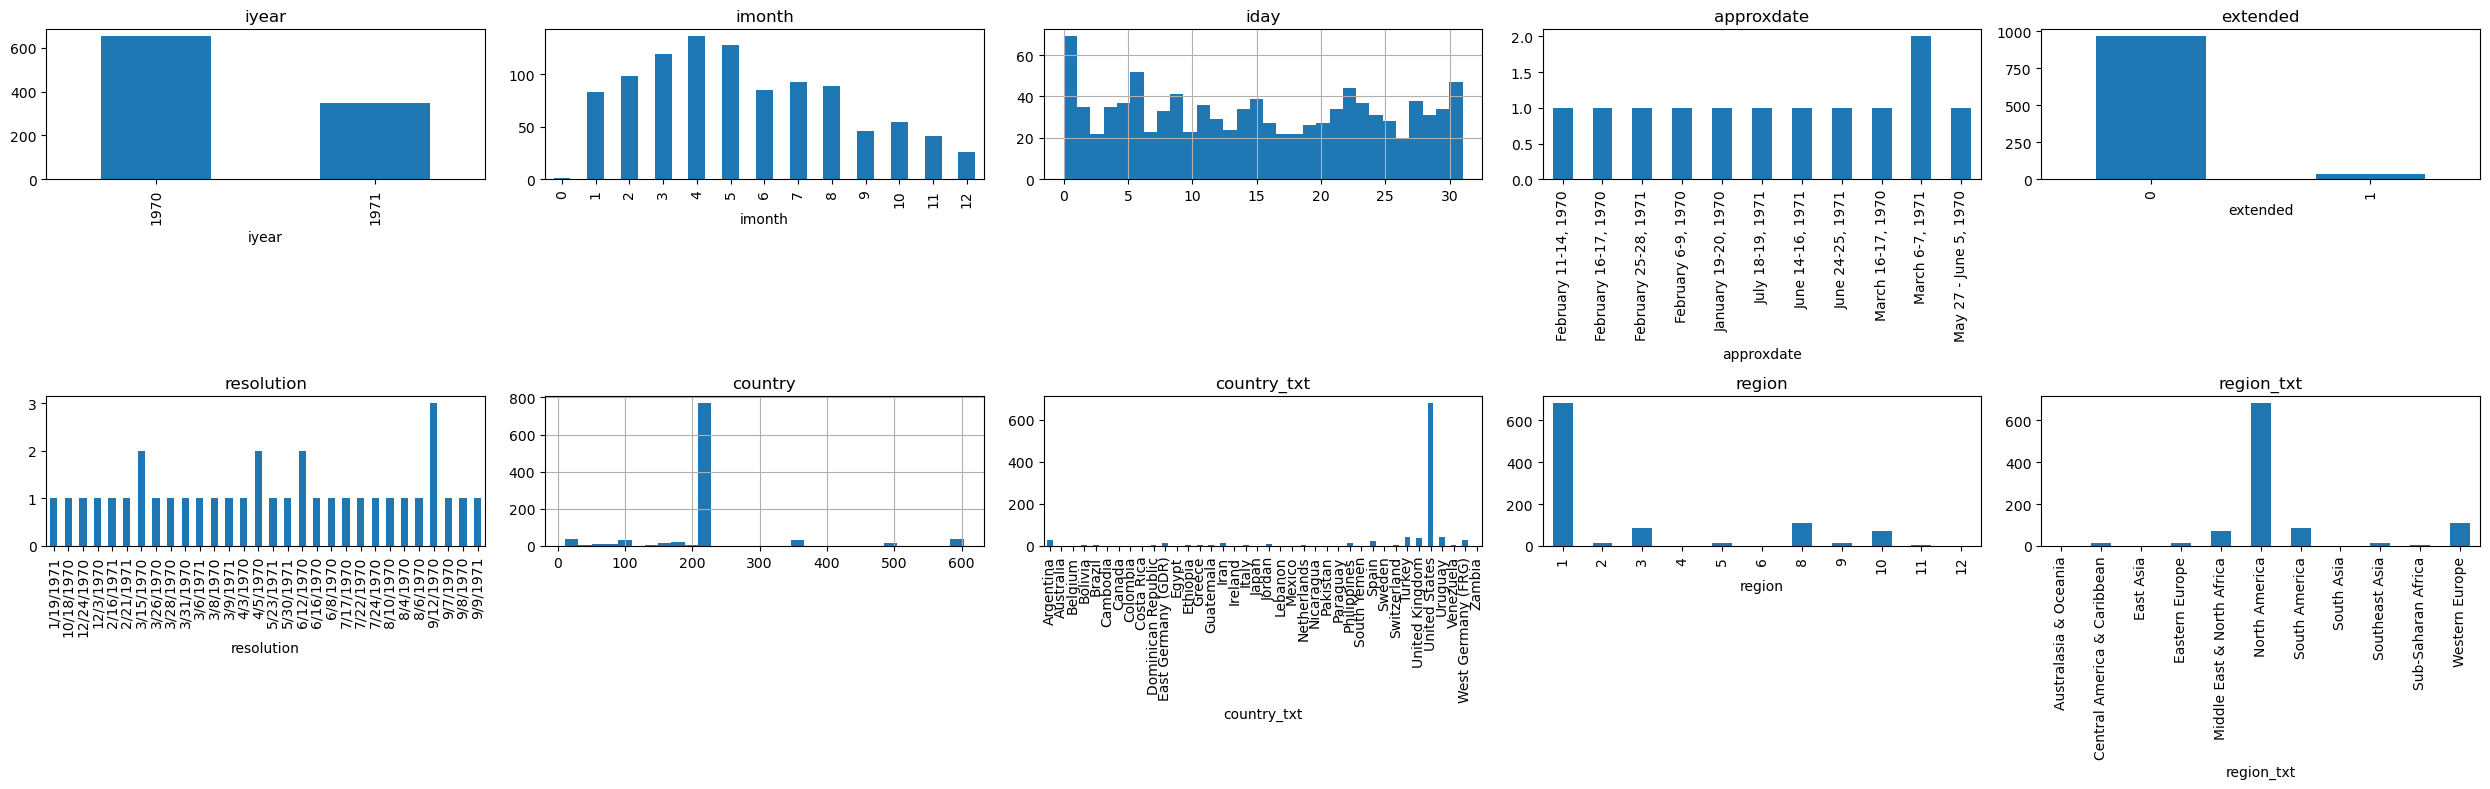

In [51]:
plotPerColumnDistribution(df1, 10, 5)


In [ ]:
#Distribution graphs (histograms/bar graphs) of column data
###def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    #nunique = df.nunique()
    #df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    #plotPerColumnDistribution(df1, 10, 5)